In [1]:
from sklearn.datasets import fetch_20newsgroups
import nltk
nltk.download('wordnet')
nltk.download('names')
nltk.download('omw-1.4')
from nltk.stem import WordNetLemmatizer
from nltk.corpus import names
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score
import re
import string
import numpy as np

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package names to /home/codespace/nltk_data...
[nltk_data]   Unzipping corpora/names.zip.
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /home/codespace/nltk_data...


In [2]:
cat = ['alt.atheism', 'talk.religion.misc', 'comp.graphics',
       'sci.space']

dataset = fetch_20newsgroups(subset='all', categories=cat)
labels = dataset.target
label_names = dataset.target_names

In [3]:
words_to_exclude = ['nntppostinghost', 'line', 'email', 'dont', 'newsgroups']

def get_lemmatized_data(data: list) -> np.array:
  data_proc = []
  lemmatizer = WordNetLemmatizer()
  for doc in data:
    doc = doc.lower()
    doc_lem = ' '.join(lemmatizer.lemmatize(word) for word in doc.split() if word not in words_to_exclude)
    data_proc.append(doc_lem)
  return np.array(data_proc)

def preproc_20newsgroup(data):
  url_re = re.compile(r'(?:http|ftp|https)://(?:[\w_-]+(?:(?:\.[\w_-]+)+))(?:[\w.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-])?')
  email_re = re.compile('(?:[a-z0-9!#$%&\'*+/=?^_`{|}~-]+(?:\.[a-z0-9!#$%&\'*+/=?^_`{|}~-]+)*|"(?:[\x01-\x08\x0b\x0c\x0e-\x1f\x21\x23-\x5b\x5d-\x7f]|\\[\x01-\x09\x0b\x0c\x0e-\x7f])*")@(?:(?:[a-z0-9](?:[a-z0-9-]*[a-z0-9])?\.)+[a-z0-9](?:[a-z0-9-]*[a-z0-9])?|\[(?:(?:(2(5[0-5]|[0-4][0-9])|1[0-9][0-9]|[1-9]?[0-9]))\.){3}(?:(2(5[0-5]|[0-4][0-9])|1[0-9][0-9]|[1-9]?[0-9])|[a-z0-9-]*[a-z0-9]:(?:[\x01-\x08\x0b\x0c\x0e-\x1f\x21-\x5a\x53-\x7f]|\\[\x01-\x09\x0b\x0c\x0e-\x7f])+)\])')
  preproc_data = []
  for doc in data:
    # Remover cabeçalho de Email
    doc = re.sub(r'(From:\s+[^\n]+\n)', '', doc)
    doc = re.sub(r'(Subject:[^\n]+\n)', '', doc)
    doc = re.sub(r'(([\sA-Za-z0-9\-]+)?[A|a]rchive-name:[^\n]+\n)', '', doc)
    doc = re.sub(r'(Last-modified:[^\n]+\n)', '', doc)
    doc = re.sub(r'(Version:[^\n]+\n)', '', doc)

    doc = doc.lower()
    doc = re.sub(url_re, '', doc)
    doc = re.sub(email_re, '', doc)
    doc = re.sub(f'[{re.escape(string.punctuation)}]', '', doc)
    doc = re.sub(r'(\d+)', ' ', doc)
    doc = re.sub(r'(\s+)', ' ', doc)
    preproc_data.append(doc)
  get_lemmatized_data(preproc_data)
  return preproc_data



In [4]:
preproc_transformer = FunctionTransformer(preproc_20newsgroup)
preproc_pipeline = Pipeline([('preproc_20groups', preproc_transformer),
                             ('tfidf', TfidfVectorizer(max_df=0.5, min_df=2, stop_words='english'))])

vect_data = preproc_pipeline.fit_transform(dataset.data)

In [5]:
K = 2
kmeans = KMeans(n_clusters=K, random_state=42)
kmeans.fit(vect_data)
clusters = kmeans.labels_
Counter(clusters)

Counter({1: 2318, 0: 1069})

In [15]:
def get_brief(model, vectorizer, labels, n_clusters, iskmeans=True):
  clusters = model.labels_
  cluster_label = {i: labels[np.where(clusters == i)] for i in range(n_clusters)}
  palavras = vectorizer.get_feature_names_out()
  if iskmeans:
    centroids = model.cluster_centers_

  for cluster, index_list in cluster_label.items():
    counter = Counter(cluster_label[cluster])
    print(f'Cluster {cluster}: {len(index_list)} amostras')
    print("=========================")
    for label_index, count in sorted(counter.items(), key=lambda x: x[1],
                                    reverse=True):
      print(f'{label_names[label_index]}: {count} amostras')
    print("=========================")
    if iskmeans:
      print("Top 10 palavras:")
      for i in centroids[cluster].argsort()[-10:]:
        print(f"{palavras[i]} ")
      print("=========================")
    print("\n")

Cluster 0: 1069 amostras
alt.atheism: 625 amostras
talk.religion.misc: 428 amostras
sci.space: 12 amostras
comp.graphics: 4 amostras
Top 10 palavras:
just 
believe 
religion 
say 
think 
jesus 
dont 
article 
people 
god 


Cluster 1: 2318 amostras
sci.space: 975 amostras
comp.graphics: 969 amostras
talk.religion.misc: 200 amostras
alt.atheism: 174 amostras
Top 10 palavras:
distribution 
graphics 
just 
know 
thanks 
like 
article 
nntppostinghost 
university 
space 




In [8]:
import matplotlib.pyplot as plt

def silhouete_plot(results,method,clusters):
	g=plt.figure(1)
	plt.plot(list(results.keys()),list(results.values()),label='Silhouette Method',color='green')
	plt.ylabel('Silhouette Score', fontsize=18)
	plt.xlabel('Clusters', fontsize=20)
	plt.xticks(fontsize=18)
	plt.yticks(fontsize=18, rotation=0)
	plt.legend(loc='upper left', prop={'size': 15})
	plt.xlim((min(results.keys()),max(results.keys())))
	plt.grid(linestyle='dotted', linewidth=1)
	plt.show()

def elbow_plot(sse,method,clusters):
  maximum=max(sse.values())
  for key in sse:
    sse[key] = float(sse[key])/maximum

  g=plt.figure(2)
  plt.plot(list(sse.keys()),list(sse.values()),label='Elbow Method',color='blue',linestyle='dashed')
  plt.ylabel('SSE', fontsize=18)
  plt.xlabel('Clusters', fontsize=20)
  plt.xticks(fontsize=18)
  plt.yticks(fontsize=18, rotation=0)
  plt.legend(loc='upper right', prop={'size': 15})
  plt.xlim((min(sse.keys()),max(sse.keys())))
  plt.grid(linestyle='dotted', linewidth=1)
  plt.show()

Testing k =  2
Testing k =  3
Testing k =  4
Testing k =  5
Testing k =  6
Testing k =  7
Testing k =  8
Testing k =  9
Testing k =  10
{2: 3316.913270325689, 3: 3304.400895714772, 4: 3293.6610998047563, 5: 3285.1657086231294, 6: 3284.678713596638, 7: 3267.160694106989, 8: 3261.0250028621663, 9: 3259.934538064098, 10: 3254.881466976446}
{2: 0.0049023477530641185, 3: 0.0030022249626140804, 4: 0.005408520788252493, 5: 0.00460791240101617, 6: 0.0053944298004576455, 7: 0.0058683471215340765, 8: 0.005298780928966714, 9: 0.005846728793223621, 10: 0.005435349091919433}


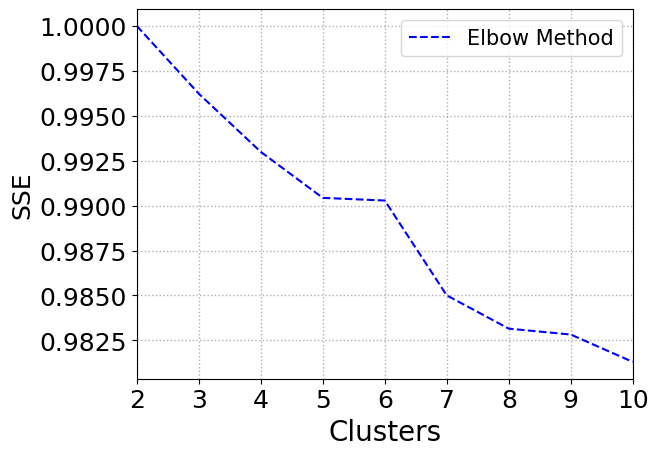

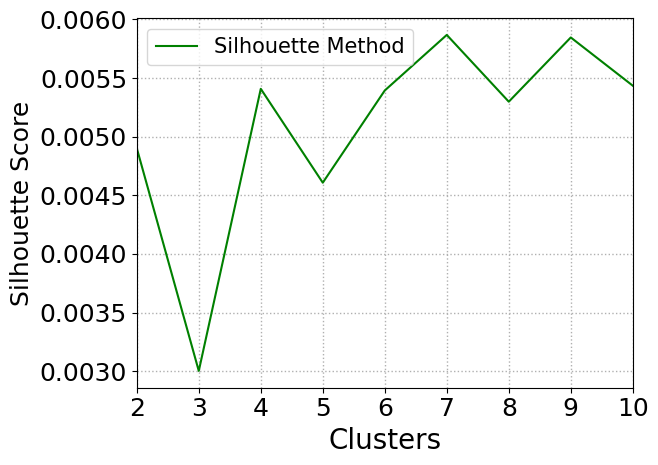

In [9]:
start = 2;	end = 10;	step = 1;
num_clusters = list(range(start,end+step,step))
sse_silhouete = {}
sse_elbow = {}

for k in num_clusters:
  print("Testing k = ",k)
  model = KMeans(n_clusters=k).fit(vect_data)
  sse_elbow[k] = model.inertia_
  predictions = model.predict(vect_data)
  sse_silhouete[k] = silhouette_score(vect_data, predictions)

print (sse_elbow)
print (sse_silhouete)
elbow_plot(sse_elbow,method='k-means',clusters=str(end))
silhouete_plot(sse_silhouete,method='k-means',clusters=str(end))

Text(0, 0.5, 'Distância')

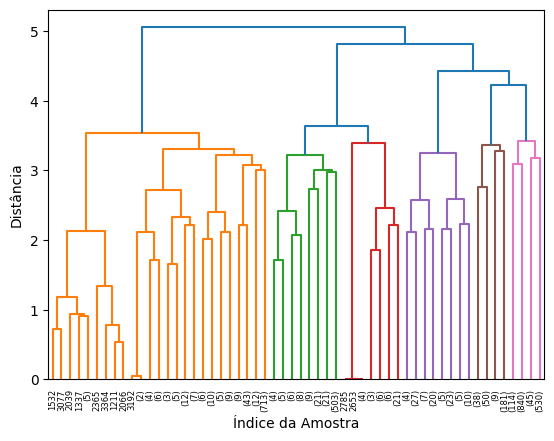

In [10]:
from scipy.cluster.hierarchy import dendrogram, ward
linkage_array = ward(vect_data.toarray())

dendrogram(linkage_array, truncate_mode='level', p=5)
ax = plt.gca()
bounds = ax.get_xbound()
plt.xlabel("Índice da Amostra")
plt.ylabel("Distância")

In [11]:
hierc = AgglomerativeClustering(n_clusters=2)
hierc.fit(vect_data.toarray())


AgglomerativeClustering()

In [12]:
get_brief(hierc, preproc_pipeline['tfidf'], labels, hierc.n_clusters_, False)

Cluster 0: 2527 amostras
sci.space: 911 amostras
alt.atheism: 781 amostras
talk.religion.misc: 618 amostras
comp.graphics: 217 amostras


Cluster 1: 860 amostras
comp.graphics: 756 amostras
sci.space: 76 amostras
alt.atheism: 18 amostras
talk.religion.misc: 10 amostras


